In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

import json
from PIL import Image 
from itertools import chain
from sklearn.model_selection import train_test_split

In [48]:
f = open("dataset/output.manifest", "r")
file=f.read()
lis=file.split('\n')

image_name=[]
properties=[]

for i in lis[:-1]:
    js = json.loads(i)
    image_name.append(js['source-ref'].split('/')[-1])
    annot=[]
    for j in js['zegar-labeling-test']['annotations']:
        label_index = [*j.values()][0]

        '''xmin = [*j.values()][1] #Top 
        ymin = [*j.values()][2] #left
        h = [*j.values()][3] #height Right
        w = [*j.values()][4] #width Bottom 

        w_img = [*js['zegar-labeling-test']['image_size'][0].values()][0] # image width
        h_img = [*js['zegar-labeling-test']['image_size'][0].values()][1]  #image height
 
        xcenter = (xmin + w/2) / w_img
        ycenter = (ymin + h/2) / h_img
        w = w / w_img
        h = h / h_img
        annot.append([label_index, xcenter, ycenter, w, h])'''
        
        
        t = [*j.values()][1] # top
        l = [*j.values()][2] # left
        h = [*j.values()][3] #height
        w = [*j.values()][4]  #width
        
        #image height and image width
        img_w, img_h = [*js['zegar-labeling-test']['image_size'][0].values()][0], [*js['zegar-labeling-test']['image_size'][0].values()][1]
        
        
        x1 = l
        y1 = t
        x2 = (l+w)
        y2 = (t+h)

        b_center_x = (x1 + x2) / 2 
        b_center_y = (y1 + y2) / 2
        b_width    = (x2 - x1)
        b_height   = (y2 - y1)
        
        # Normalise the co-ordinates by the dimensions of the image
        b_center_x /= img_w 
        b_center_y /= img_h 
        b_width    /= img_w 
        b_height   /= img_h 

        #annot.append([label_index,x1, y1, x2, y2])
        annot.append([label_index,b_center_x, b_center_y, b_width, b_height])

    properties.append(annot)
    

images_train, images_test, labels_train, labels_test = train_test_split(image_name, properties, test_size=0.2, random_state=42)


for i , j in zip(images_train, labels_train):
    if(len(j)>0):
        im1 = Image.open('dataset/'+i) 

        im1.save('train_data/train/images/'+i)
        with open('train_data/train/labels/'+i.split('.')[0]+".txt", "w") as outfile:
            
            for line in j:
                for inline in line:
                    outfile.write(f" {inline}")
                outfile.write(f"\n")
    else:
        print(f"{i} has no annotation")

        
        
        
        
        
for i , j in zip(images_test, labels_test):
    if(len(j)>0): 
        im1 = Image.open('dataset/'+i) 

        im1.save('train_data/val/images/'+i)
        with open('train_data/val/labels/'+i.split('.')[0]+".txt", "w") as outfile:
            for line in j:
                for inline in line:
                    outfile.write(f" {inline}")
                outfile.write(f"\n")
    else:
        print(f"{i} has no annotation")
                              
                              

26069_Montecristo_No4_10S_sta_pac_1024x1024.jpeg has no annotation
Monte_NO3_10s_.jpeg has no annotation
Montecristo-No.4.jpg has no annotation
IMG_20220224_173616.jpg has no annotation
MX3-0__36171.1521659607.jpg has no annotation
montecristo_nr3_singel_ok.jpeg has no annotation
montecristo_nr4_singel_ok.jpeg has no annotation
IMG_20220224_173611.jpg has no annotation
IMG_20220224_172428.jpg has no annotation


In [19]:
class_names = ['logo1', 'logo2']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [10]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [11]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(float(labels[box_num]))]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [12]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_samples-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                
                label = label_line[1]
                #print(label_line[1])
                bbox_string = label_line[2:]
                #print(bbox_string.replace('\n','').split(' ')[1:])
                #print([float(i) for i in bbox_string.replace('\n','').split(' ') if(i !='' and i != ' ')])
                x_c, y_c, w, h = [i for i in bbox_string.replace('\n','').split(' ') if i !='' and i != ' ']
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)

        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

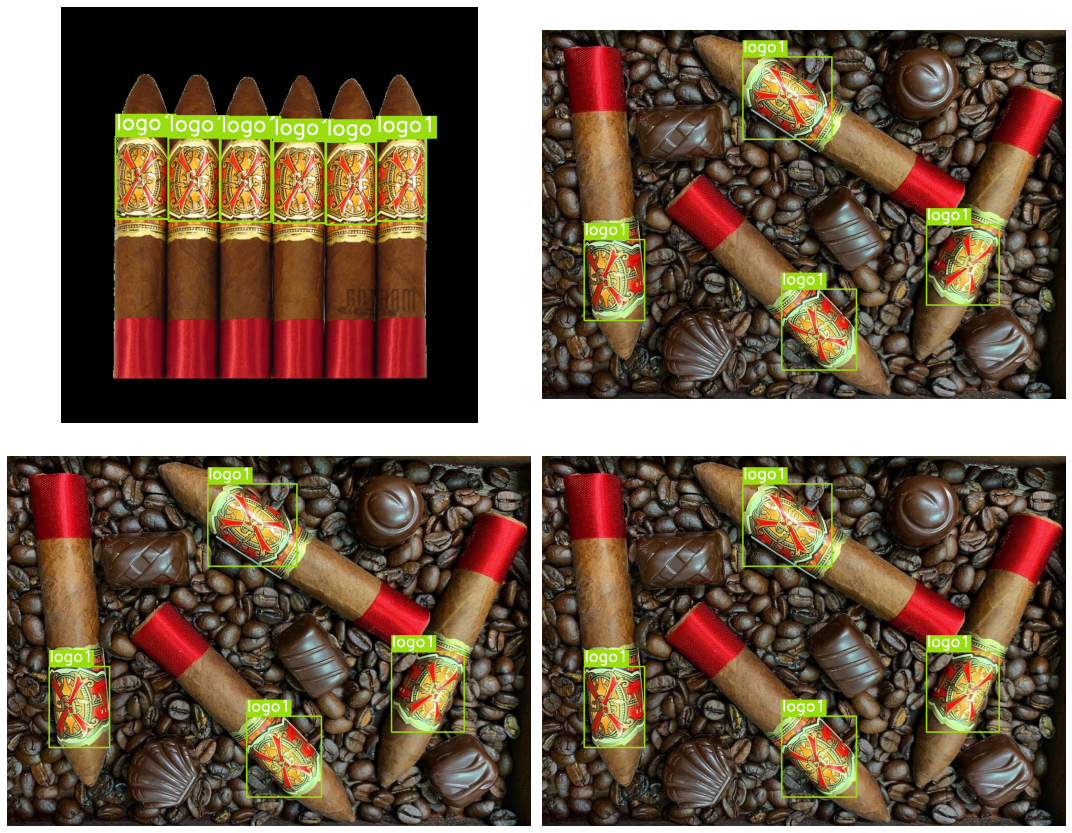

In [50]:
# Visualize a few training images.
plot(
    image_paths='train_data/train/images/*', 
    label_paths='dataset/train_data/train/labels/*',
    num_samples=4
)